# Passive

Plots a passive learning curve w.r.t. ATLAS objects. Trained, tested on RGZ, split on compact/resolved. Testing on RGZ instead of Norris because we believe it to be reasonably accurate and it's also a *lot* bigger; if we want a good idea of how this curve levels out we really want to use as much data as possible. Splitting on compact/resolved because we expect compact to level out a lot faster (possibly *very* fast indeed).

In [5]:
import astropy.io.ascii as asc, numpy, h5py, sklearn.linear_model, crowdastro.crowd.util, pickle, scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('/Users/alger/data/Crowdastro/sets_atlas.pkl', 'rb') as f:
    atlas_sets = pickle.load(f)
    atlas_sets_compact = atlas_sets['RGZ & compact']
    atlas_sets_resolved = atlas_sets['RGZ & resolved']
with open('/Users/alger/data/Crowdastro/sets_swire.pkl', 'rb') as f:
    swire_sets = pickle.load(f)
    swire_sets_compact = swire_sets['RGZ & compact']
    swire_sets_resolved = swire_sets['RGZ & resolved']
with h5py.File('/Users/alger/data/Crowdastro/swire.h5') as f:
    swire_features = f['features'].value
with h5py.File('/Users/alger/data/Crowdastro/crowdastro-swire.h5') as f:
    swire_names = [i.decode('ascii') for i in f['/swire/cdfs/string'].value]
    swire_coords = f['/swire/cdfs/numeric'][:, :2]
swire_labels = {i['swire']: i['rgz_label'] for i in asc.read('/Users/alger/data/SWIRE/all_labels.csv')}
table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')
swire_tree = scipy.spatial.KDTree(swire_coords)

## Compact

In [13]:
def test_on_atlas_sets(atlas_sets, swire_sets):

    subset_sizes = numpy.logspace(numpy.log2(5),
                                  numpy.log2(len(atlas_sets[0][0])),
                                  base=2, num=10)

    n_atlas = []
    n_swire = []
    bas = []

    for (train, test), (_, test_swire) in zip(atlas_sets, swire_sets):
        key_to_row = {}
        for row in table:
            key_to_row[row['Key']] = row
        for subset_size in subset_sizes:
            print(subset_size, end=' ')
            # Subsample train.
            subset_size = int(subset_size)
            train_subset = list(train)
            numpy.random.shuffle(train_subset)
            train_subset = train_subset[:subset_size]
            # Get coords.
            ras = [key_to_row[k]['Component RA (Franzen)'] for k in train_subset]
            decs = [key_to_row[k]['Component DEC (Franzen)'] for k in train_subset]
            coords = list(zip(ras, decs))
            # Find nearby SWIREs.
            nearby = sorted({int(i) for i in numpy.concatenate(swire_tree.query_ball_point(coords, 1 / 60))})
            # Train on the features.
            features = swire_features[nearby]
            labels = [swire_labels[swire_names[n]] == 'True' for n in nearby]
            lr = sklearn.linear_model.LogisticRegression(class_weight='balanced', C=1e10)
            lr.fit(features, labels)
            # Compute accuracy.
            test_labels = [swire_labels[swire_names[n]] == 'True' for n in test_swire]
            test_features = swire_features[test_swire]
            acc = crowdastro.crowd.util.balanced_accuracy(test_labels, lr.predict(test_features))
            n_atlas.append(int(subset_size))
            n_swire.append(len(nearby))
            bas.append(acc)
        print()
    
    return n_atlas, n_swire, bas

In [ ]:
n_atlas, n_swire, bas = test_on_atlas_sets(atlas_sets_compact, swire_sets_compact)

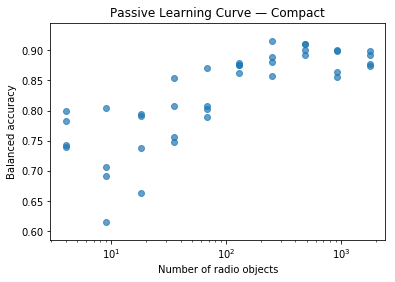

In [9]:
plt.scatter(n_atlas, bas, alpha=0.7)
plt.title('Passive Learning Curve — Compact')
plt.xlabel('Number of radio objects')
plt.ylabel('Balanced accuracy')
plt.xscale('log')

## Resolved

In [14]:
n_atlas_resolved, n_swire_resolved, bas_resolved = test_on_atlas_sets(atlas_sets_resolved, swire_sets_resolved)

5.0 7.61718846255 11.6043120148 17.678446319 26.9320114673 41.0292414044 62.5054928506 95.2232237974 145.066648335 221.0 
5.0 7.61718846255 11.6043120148 17.678446319 26.9320114673 41.0292414044 62.5054928506 95.2232237974 145.066648335 221.0 
5.0 7.61718846255 11.6043120148 17.678446319 26.9320114673 41.0292414044 62.5054928506 95.2232237974 145.066648335 221.0 
5.0 7.61718846255 11.6043120148 17.678446319 26.9320114673 41.0292414044 62.5054928506 95.2232237974 145.066648335 221.0 


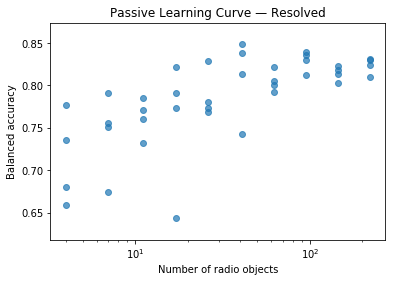

In [15]:
plt.scatter(n_atlas_resolved, bas_resolved, alpha=0.7)
plt.title('Passive Learning Curve — Resolved')
plt.xlabel('Number of radio objects')
plt.ylabel('Balanced accuracy')
plt.xscale('log')

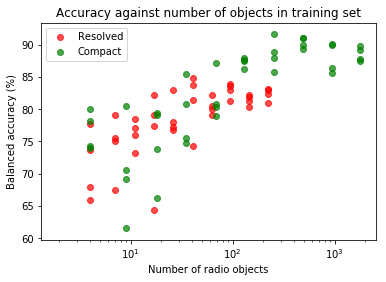

In [21]:
plt.scatter(n_atlas_resolved, numpy.array(bas_resolved) * 100, alpha=0.7, color='red', label='Resolved')
plt.scatter(n_atlas, numpy.array(bas) * 100, alpha=0.7, color='green', label='Compact')
plt.title('Accuracy against number of objects in training set')
plt.xlabel('Number of radio objects')
plt.ylabel('Balanced accuracy (%)')
plt.xscale('log')
plt.legend()

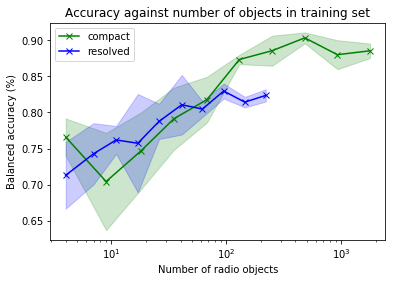

In [44]:
n_atlas_to_acc_compact = {n: [] for n in n_atlas}
for n, ba in zip(n_atlas, bas):
    n_atlas_to_acc_compact[n].append(ba)
xs_compact = []
ys_compact = []
yerr_compact = []
for n in sorted(set(n_atlas)):
    xs_compact.append(n)
    ys_compact.append(numpy.mean(n_atlas_to_acc_compact[n]))
    yerr_compact.append(numpy.std(n_atlas_to_acc_compact[n]))
xs_compact = numpy.array(xs_compact)
ys_compact = numpy.array(ys_compact)
yerr_compact = numpy.array(yerr_compact)
ylow_compact = ys_compact - yerr_compact
yhigh_compact = ys_compact + yerr_compact

n_atlas_to_acc_resolved = {n: [] for n in n_atlas_resolved}
for n, ba in zip(n_atlas_resolved, bas_resolved):
    n_atlas_to_acc_resolved[n].append(ba)
xs_resolved = []
ys_resolved = []
yerr_resolved = []
for n in sorted(set(n_atlas_resolved)):
    xs_resolved.append(n)
    ys_resolved.append(numpy.mean(n_atlas_to_acc_resolved[n]))
    yerr_resolved.append(numpy.std(n_atlas_to_acc_resolved[n]))
xs_resolved = numpy.array(xs_resolved)
ys_resolved = numpy.array(ys_resolved)
yerr_resolved = numpy.array(yerr_resolved)
ylow_resolved = ys_resolved - yerr_resolved
yhigh_resolved = ys_resolved + yerr_resolved

plt.plot(xs_compact, ys_compact, alpha=1, color='green', label='compact', marker='x')
plt.fill_between(xs_compact, ylow_compact, yhigh_compact, alpha=.2, color='green')
plt.plot(xs_resolved, ys_resolved, alpha=1, color='blue', label='resolved', marker='x')
plt.fill_between(xs_resolved, ylow_resolved, yhigh_resolved, alpha=.2, color='blue')
plt.title('Accuracy against number of objects in training set')
plt.xlabel('Number of radio objects')
plt.ylabel('Balanced accuracy (%)')
plt.xscale('log')
plt.legend()
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/passive.pdf')